Leafs speacies from the dataset : 


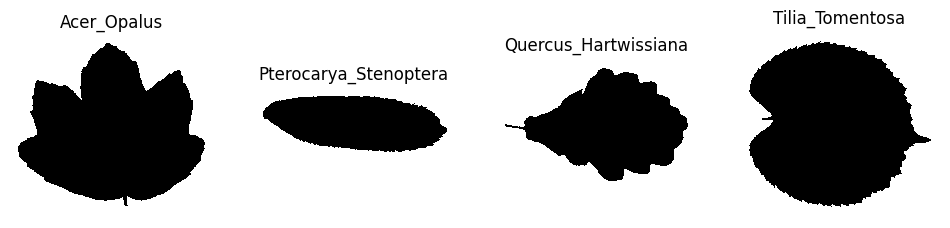

In [8]:
# Classification with images. 

print('Leafs speacies from the dataset : ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes, data.x_image_tab, data.y_tab):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')

In [9]:
# Create a classifier: a support vector classifier
# clf = svm.SVC(gamma=0.001)
clf = RandomForestClassifier(n_jobs=-1)
# clf = KNeighborsClassifier(6, n_jobs=-1)
# clf = LinearDiscriminantAnalysis()
# clf = AdaBoostClassifier()
# clf = GradientBoostingClassifier()

# Learn the digits on the train subset
clf.fit(data.x_image_train, data.y_image_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(data.x_image_test)

Those images are smaller than the original ones, because they have been resized.

Predicted values : 


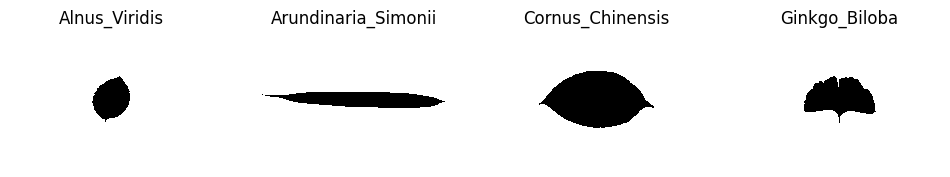

In [10]:
print('Those images are smaller than the original ones, because they have been resized.\n')

print('Predicted values : ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, prediction in zip(axes, data.x_image_test, predicted):
    ax.set_axis_off()
    image = image.reshape(data.resized_images_width, data.resized_images_height)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{prediction}')

Classification report for classifier RandomForestClassifier(n_jobs=-1):
                              precision    recall  f1-score   support

             Acer_Capillipes       0.67      1.00      0.80         2
             Acer_Circinatum       0.50      1.00      0.67         2
                   Acer_Mono       1.00      1.00      1.00         2
                 Acer_Opalus       0.50      0.50      0.50         2
               Acer_Palmatum       1.00      1.00      1.00         2
                 Acer_Pictum       1.00      1.00      1.00         2
             Acer_Platanoids       1.00      1.00      1.00         2
                 Acer_Rubrum       0.33      0.50      0.40         2
              Acer_Rufinerve       0.67      1.00      0.80         2
            Acer_Saccharinum       0.00      0.00      0.00         2
               Alnus_Cordata       1.00      1.00      1.00         2
          Alnus_Maximowiczii       0.33      0.50      0.40         2
                 

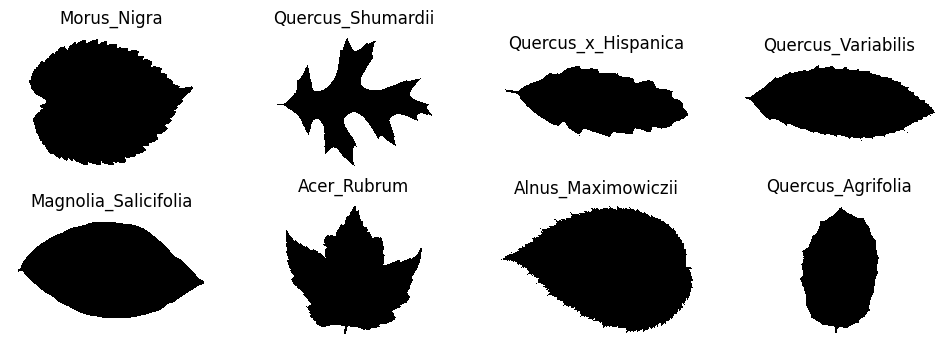

In [11]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(data.y_image_test, predicted)}\n"
)

report = metrics.classification_report(data.y_image_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
# Some targets are missing in the test set and due to this fact, the precision and recall are replaced by 0.
# So, we will remove them from the report.
df = df[df['f1-score'] != 0]

# Then, we keep the 10 leaf species with the worst f1-score.
worst_leaf_names = df.sort_values(by=['f1-score'], ascending=True)[:10].index.values

worst_leaf_indexes = [np.where(data.y_tab == name)[0][0] for name in worst_leaf_names]
worst_images = [data.x_image_tab[i] for i in worst_leaf_indexes]
worst_labels = [data.y_tab[i] for i in worst_leaf_indexes]

print('The leaf species with the worst f1-score are the following: ')
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes.flatten(), worst_images, worst_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')